In [1]:
#8.3 Lab: Tree-Based Methods
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [397]:
import statsmodels.api as sm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
DecisionTreeRegressor as DTR,
plot_tree,
export_text)
from sklearn.metrics import (accuracy_score,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RF,
GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [ ]:
#8.3.1 Fitting Classifcation Trees

In [5]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

In [14]:
# form a model matrix
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [28]:
#set random_state for reproducibility
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [20]:
accuracy_score(High, clf.predict(X))

0.79

In [23]:
#nmk is the number of observations in the mth terminal node that belong to the kth class.
#closely related to the entropy,
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.4710647062649358

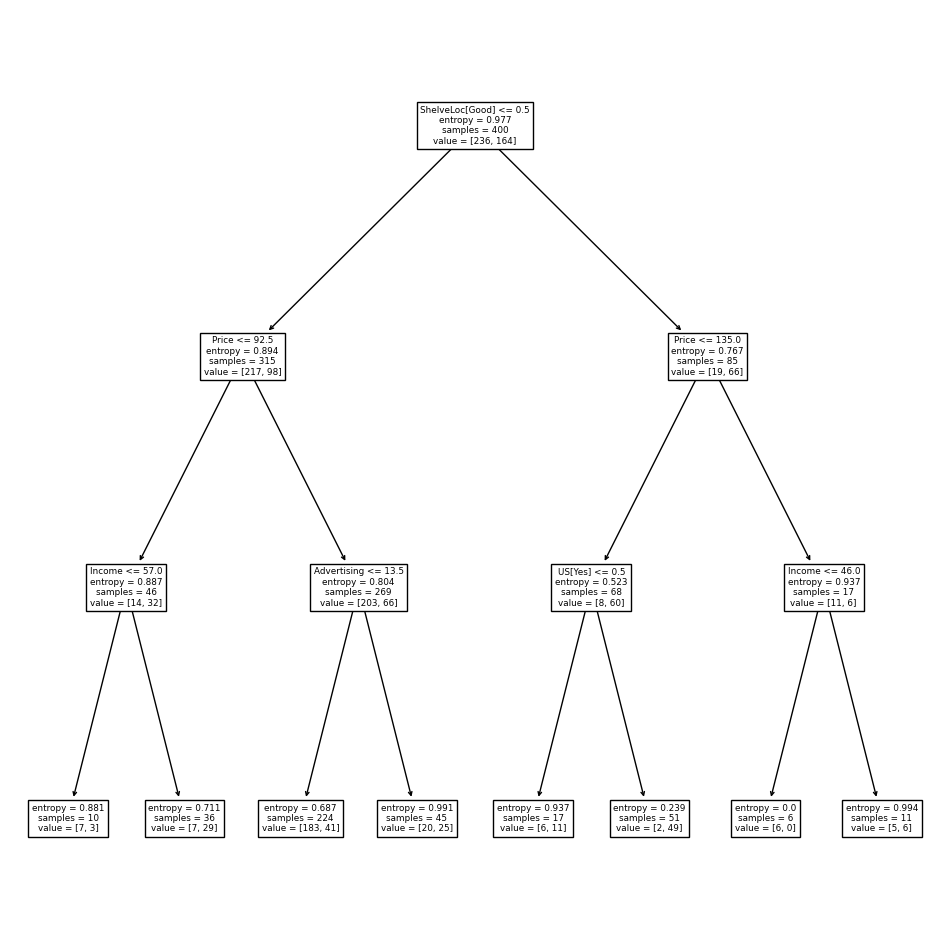

In [26]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [ ]:
# most important indicator of Sales appears to be ShelveLoc.

In [27]:
# see a text representation of the tree using export_text()
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [ ]:
#estimate the test error rather than simply computing the training error

In [29]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']

array([0.685])

In [ ]:
#This approach leads to correct predictions for 68.5% of the locations in the test data set.

In [30]:
#whether pruning the tree might lead to improved classifcation performance
# split the data into a training and test set.

(X_train,
X_test,
High_train,
High_test) = skm.train_test_split(X,
                                  High,
                                  test_size=0.5,
                                  random_state=0)

In [31]:
#refit the full tree on the training set
#do not set a max_depth,learn that through cross-validation
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [43]:
clf.tree_.n_leaves

35

In [33]:
# extract cost-complexity values
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

In [39]:
#yields a set of impurities and α values
#extract an optimal one by cross-validation
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')

grid.fit(X_train, High_train)
grid.best_score_

0.685

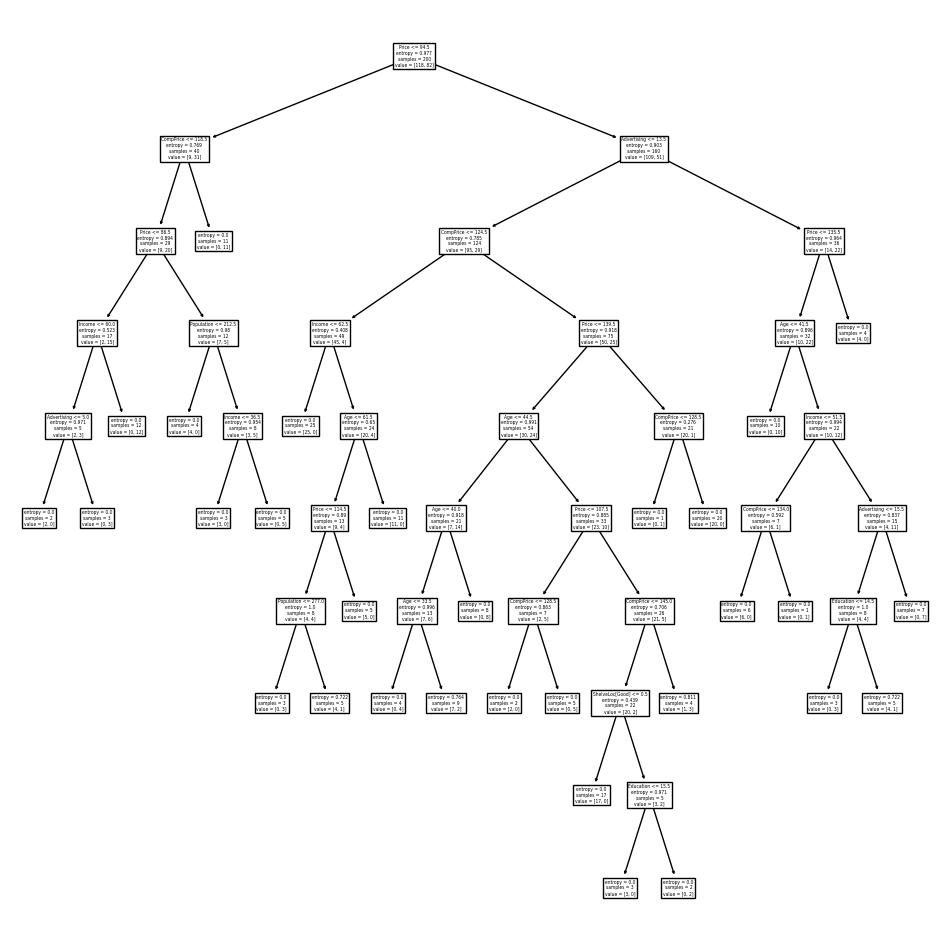

In [40]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

In [41]:
best_.tree_.n_leaves

30

In [ ]:
#The tree with 30 terminal nodes results in the lowest cross-validation error rate, with an accuracy of 68.5%.

In [42]:
print(accuracy_score(High_test, 
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


In [ ]:
# 72.0% of the test observations are correctly classifed
#slightly worse than the error for the full tree (with 35 leaves).

In [ ]:
################################
#8.3.2 Fitting Regression Trees

In [44]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [46]:
#fit the tree to training set
#use 30% of the data for the test set.
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                               Boston['medv'],
                               test_size=0.3,
                               random_state=0)

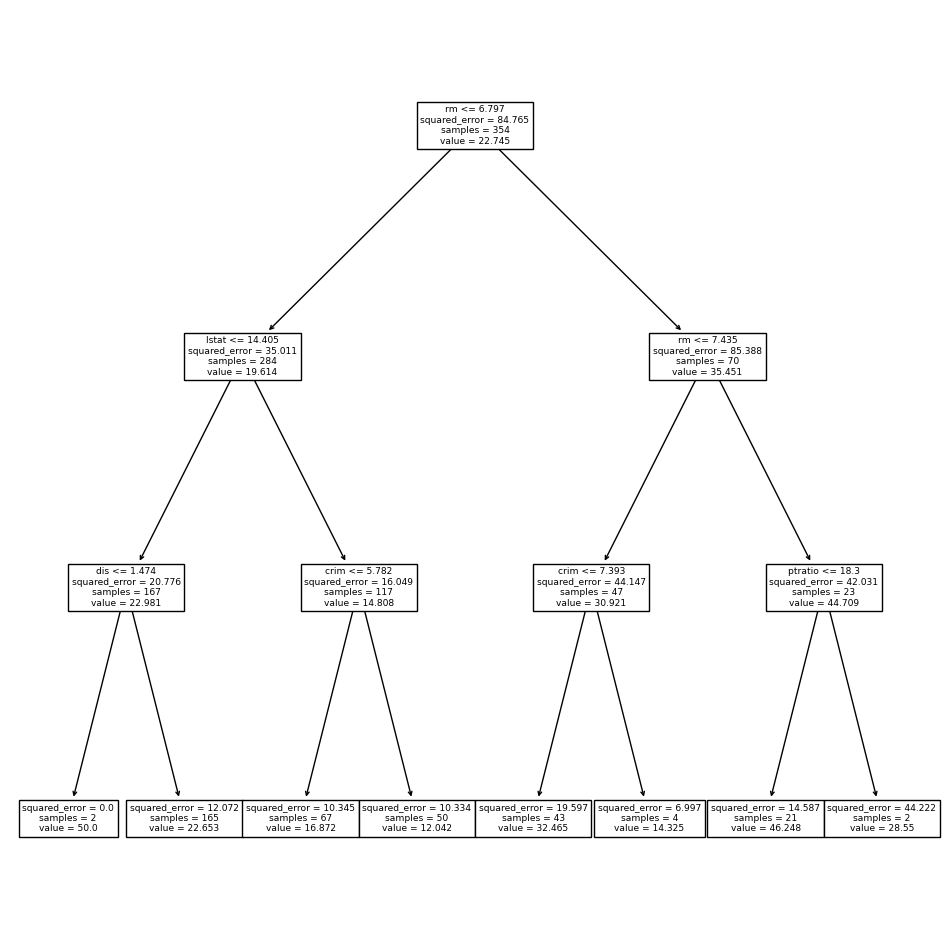

In [47]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [ ]:
#The tree predicts a median house price of $12,042 for small-sized homes (rm < 6.8),

In [50]:
#use the cross-validation function to see whether pruning the tree will improve performance
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [51]:
#use the prune tree to predict
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

In [ ]:
# test set MSE associated with the regression tree is 28.07.
# square root of the MSE is therefore around 5.30, 
# indicating that this model leads to test predictions that are within around $5300 of the true median home value for the suburb.

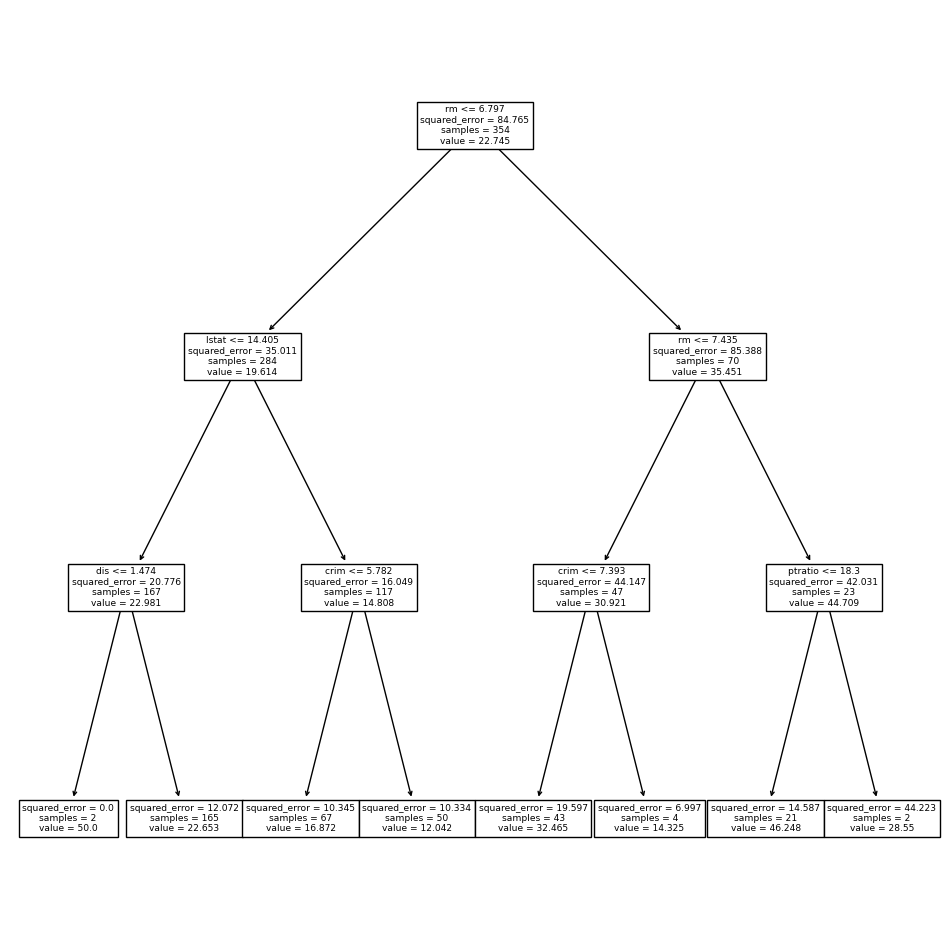

In [52]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

In [54]:
best_.tree_.n_leaves

8

In [55]:
reg.tree_.n_leaves

8

In [ ]:
################8.3.3 Bagging and Random Forests

In [58]:
#RandomForestRegressor() function can be used to perform both bagging and random forests
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

In [59]:
#max_features indicates that all 12 predictors should be considered for each split of the tree

14.684333796052627

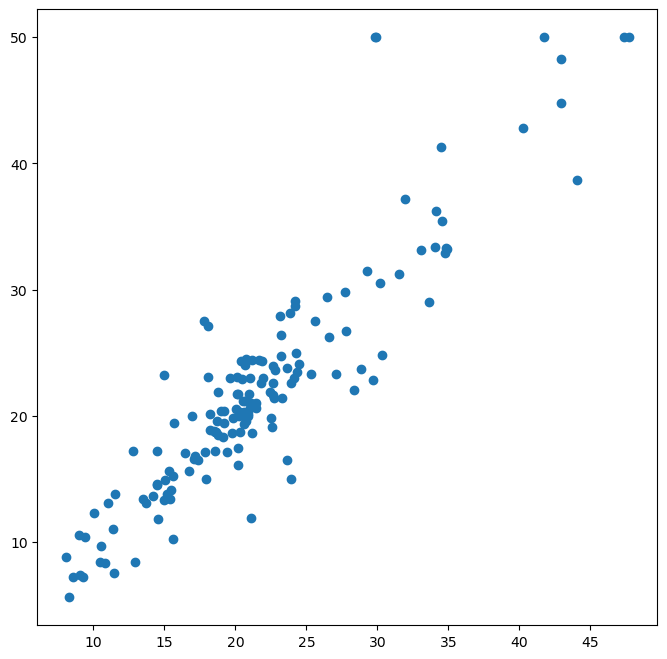

In [60]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [65]:
#could change the number of trees grown from the default of 100 by using the n_estimators argument
bag_boston = RF(max_features=X_train.shape[1], #bagging
                n_estimators=500, #100 in previous model
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.565312103157904

In [66]:
RF_boston = RF(max_features=6, #it defaults to bagging,p
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

19.998839111842113

In [67]:
#indicates that random forests did somewhat worse than bagging in this case.

In [68]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.353808
rm,0.334349
ptratio,0.069519
crim,0.056386
indus,0.053183
dis,0.043762
nox,0.033085
tax,0.025047
age,0.019238
rad,0.005169


In [ ]:
#The results indicate that across all of the trees considered in the random forest, 
#the wealth level of the community (lstat) and the house size (rm) are by far the two most important variables.

In [ ]:
################################
#8.3.4 Boosting

In [69]:
boost_boston = GBR(n_estimators=5000,# want 5000 trees
                   learning_rate=0.001,
                   max_depth=3, #limits the depth of each tree.
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

In [ ]:
#see how the training error decreases with the train_score_ attribute
# how the test error decreases we can use the staged_predict() method to get the predicted values along the path.

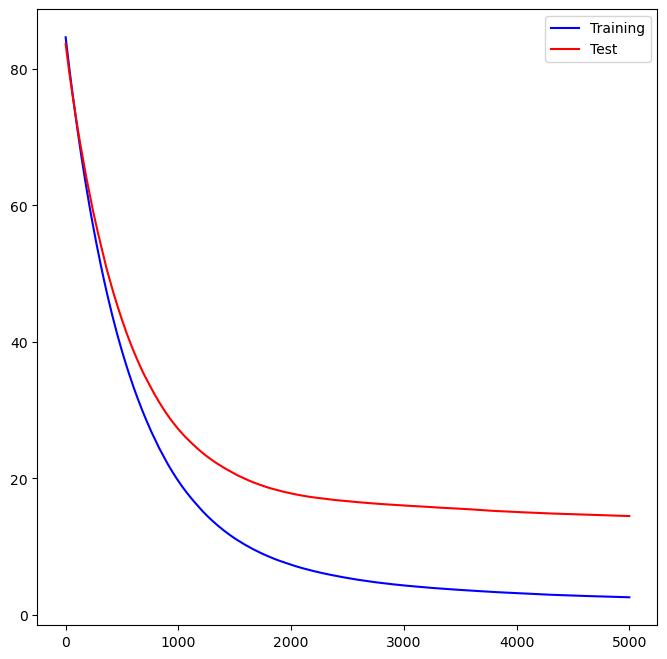

In [70]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)
plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [71]:
# use the boosted model to predict medv
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.478980532887332

In [72]:
#change the lamda from 0.001 to 0.2
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719568

In [ ]:
#In this case, using λ = 0.2 leads to a almost the same test MSE as when using λ = 0.001.

In [ ]:
#######################
#8.3.5 Bayesian Additive Regression Trees

In [73]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [75]:
#test error of BART is similar to that of random forest
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109225

In [76]:
#check how many times each variable appeared in the collection of trees
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                          index=D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64

In [77]:
#######################

In [ ]:
#7.a more comprehensive range of values for max_features and n_estimators.

In [82]:
#fit the tree to training set
#use 50% of the data for the test set.
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                               Boston['medv'],
                               test_size=0.5,
                               random_state=0)

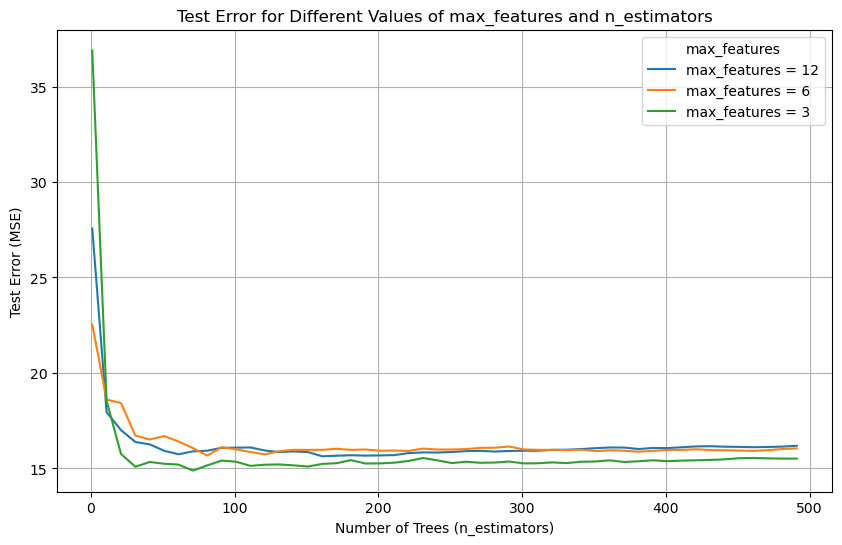

In [83]:
max_features_range = [X_train.shape[1], X_train.shape[1] // 2, int(np.sqrt(X_train.shape[1]))]  # m = p, m = p/2, m = sqrt(p)
n_estimators_range = np.arange(1, 501, 10)  

test_errors = np.zeros((len(max_features_range), len(n_estimators_range)))

for i, max_features in enumerate(max_features_range):
    for j, n_estimators in enumerate(n_estimators_range):
        RF_boston = RF(max_features=max_features, n_estimators=n_estimators, random_state=0)
        RF_boston.fit(X_train, y_train)
        
        y_hat_RF = RF_boston.predict(X_test)
        mse = np.mean((y_test - y_hat_RF)**2)
        
        test_errors[i, j] = mse

plt.figure(figsize=(10, 6))
for i, max_features in enumerate(max_features_range):
    plt.plot(n_estimators_range, test_errors[i, :], label=f'max_features = {max_features}')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Test Error (MSE)')
plt.title('Test Error for Different Values of max_features and n_estimators')
plt.legend(title='max_features')
plt.grid(True)
plt.show()

In [ ]:
#m = int(np.sqrt(X_train.shape[1])) results in the smallest MSE

In [ ]:
#8.predict Sales using regression trees and related approaches,

In [102]:
Carseats = load_data('Carseats')
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)
#use 30% of the data for the test set.
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                               Carseats['Sales'],
                               test_size=0.3,
                               random_state=0)

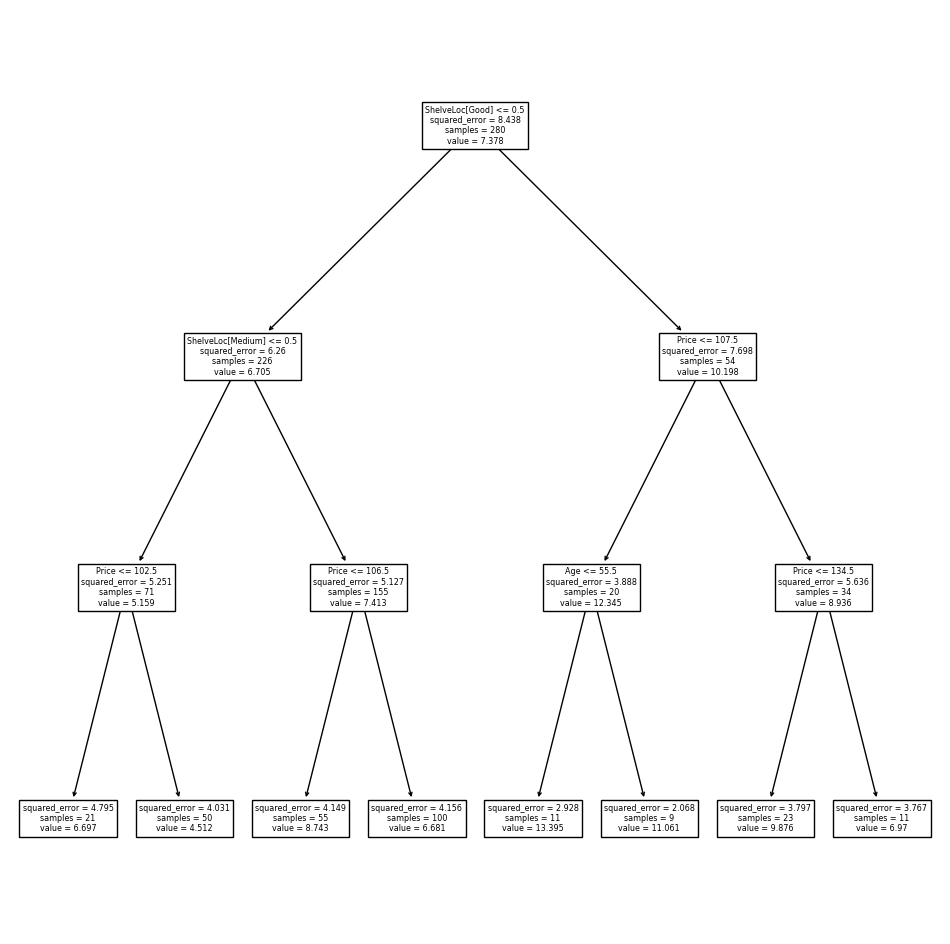

In [103]:
#(b) Fit a regression tree to the training set.
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [101]:
np.mean((y_test - reg.predict(X_test))**2)

3.7038582752360947

In [108]:
# c)Use cross-validation
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=0)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [109]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

3.6714536191308498

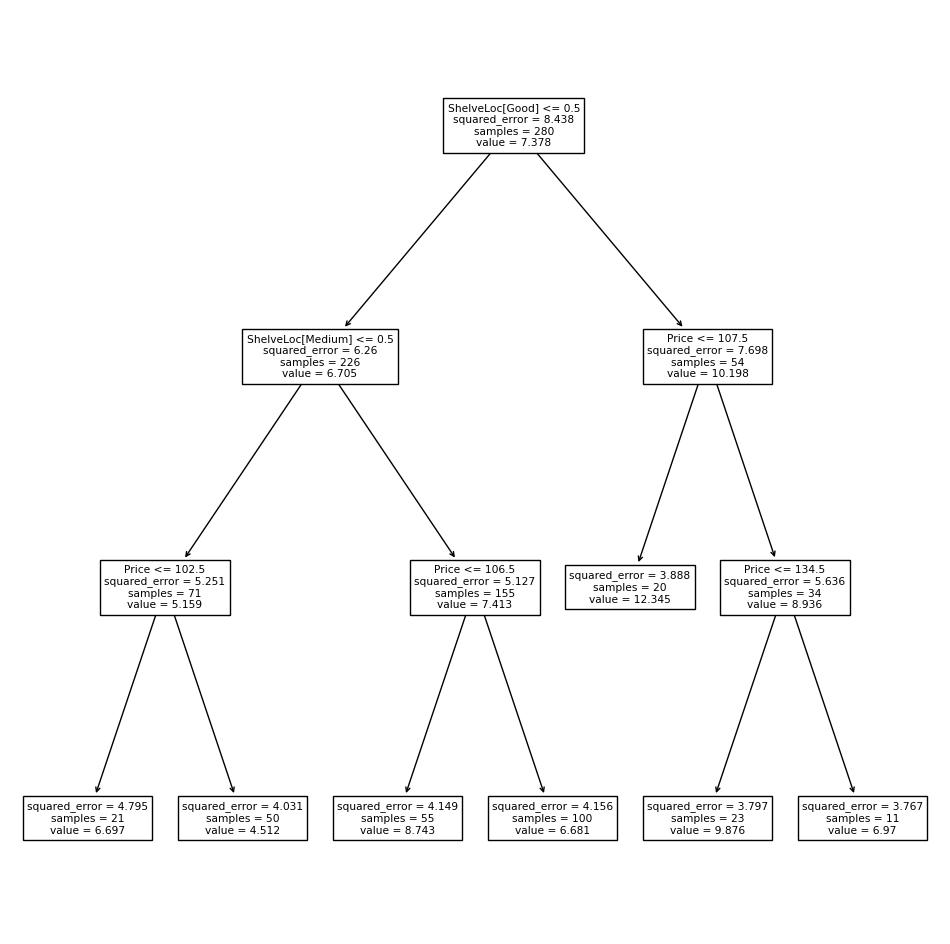

In [110]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

In [111]:
print(best_.tree_.n_leaves,reg.tree_.n_leaves)

7 8


In [ ]:
# pruning the tree doesn't improve the test MSE

2.022357787630009

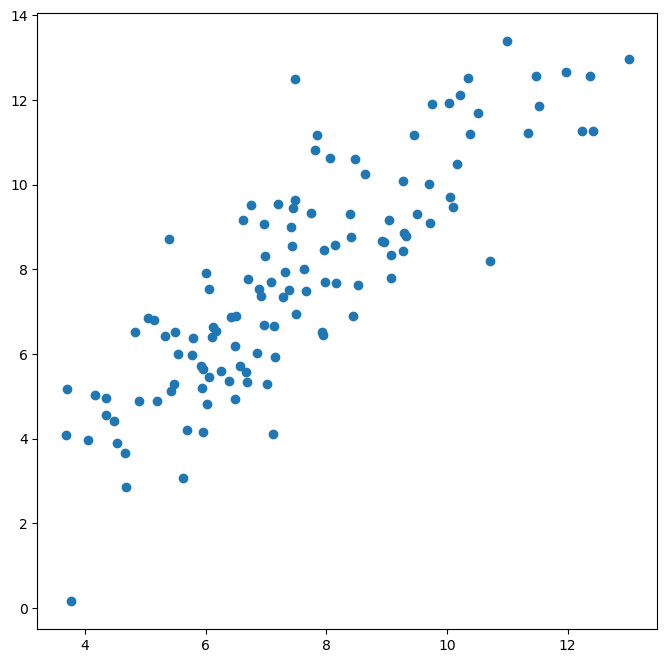

In [113]:
#d) the bagging approach
bag_Carseats = RF(max_features=X_train.shape[1],
                  n_estimators=500,
                  random_state=0)
bag_Carseats.fit(X_train, y_train)
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_Carseats.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [114]:
feature_imp = pd.DataFrame(
    {'importance':bag_Carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.286739
ShelveLoc[Good],0.220032
Age,0.105334
CompPrice,0.100722
ShelveLoc[Medium],0.085106
Advertising,0.068797
Income,0.053542
Population,0.039245
Education,0.029526
US[Yes],0.006573


In [116]:
#e) Use random forests
RF_Carseats = RF(max_features=int(np.sqrt(X_train.shape[1])),
                 random_state=0).fit(X_train, y_train)
y_hat_RF = RF_Carseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

2.3081906261666654

In [ ]:
#The test set MSE is 2.31; this indicates that random forests(with smaller m) did somewhat worse than bagging in this case.

In [117]:
feature_imp = pd.DataFrame(
    {'importance':RF_Carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.251774
ShelveLoc[Good],0.151880
Age,0.123050
CompPrice,0.094249
Advertising,0.093043
Income,0.088340
Population,0.070033
Education,0.049216
ShelveLoc[Medium],0.045724
US[Yes],0.019114


In [118]:
#(f) Now analyze the data using BART, and report your results
bart_Carseats = BART(random_state=0, burnin=5, ndraw=15)
bart_Carseats.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [119]:
yhat_test = bart_Carseats.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

1.7171824254893668

In [ ]:
#test error of BART is smaller than that of random forest and bagging

In [223]:
####9.
OJ = load_data('OJ')

In [224]:
model = MS(OJ.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(OJ)
feature_names = list(D.columns)
X = np.asarray(D)
#use 800 of the data for the training set.
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                               OJ['Purchase'],
                               train_size=800,
                               random_state=0)

In [225]:
#b)Fit a tree to the training data;classification
clf = DTC(criterion='entropy',
          random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [226]:
#training error rate
accuracy_score(y_train, clf.predict(X_train))

0.99125

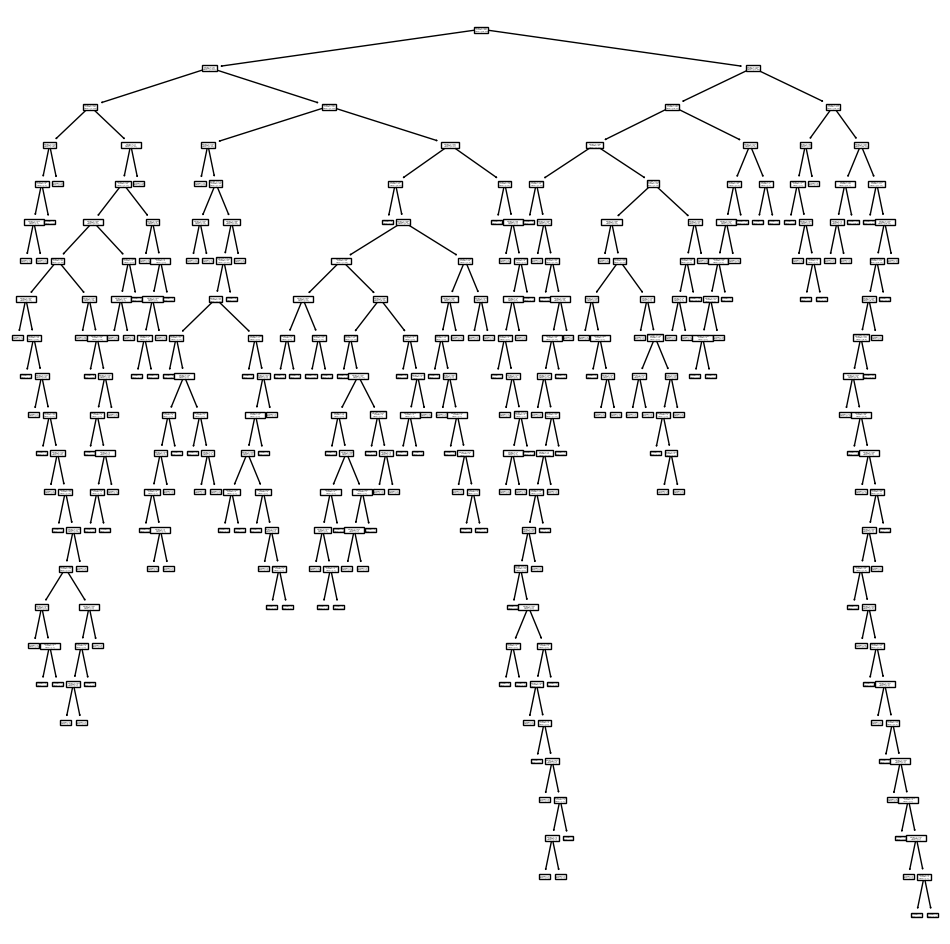

In [227]:
#c) Create a plot of the tree
ax = subplots(figsize=(12, 12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [230]:
##The tree with 168 terminal nodes 
clf.tree_.n_leaves

168

In [231]:
#d)
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- STORE <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |   |--- WeekofPurchase >  269.50
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: MM
|   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |--- weights: [0.00, 3.00] class: MM
|   |   |   |--- STORE >  2.50
|   |   |   |   |--- weights: [0.00, 43.00] class: MM
|   |   |--- LoyalCH >  0.04
|   |   |   |--- WeekofPurchase <= 273.50
|   |   |   |   |--- SalePriceCH <= 1.94
|   |   |   |   |   |--- WeekofPurchase <= 263.50
|   |   |   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |   |   |--- WeekofPurchase <= 228.00
|   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |   |   |   |--- WeekofPurchase >  228.00
|   |   |   |   |   |   |   |   |--- LoyalCH <= 0.04
|   |   |   |

In [232]:
#test error
1 - accuracy_score(y_test, clf.predict(X_test))

0.22962962962962963

In [233]:
#f)Use cross-validation to determine the optimal tree size.
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=0,
                  shuffle=True)

In [234]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')

grid.fit(X_train, y_train)
grid.best_score_

0.8075000000000001

In [235]:
#The tree with 8 terminal nodes 
best_.tree_.n_leaves

8

In [ ]:
##The tree with 8 terminal nodes results in the lowest cross-validation error rate, with an accuracy of 80.75%.

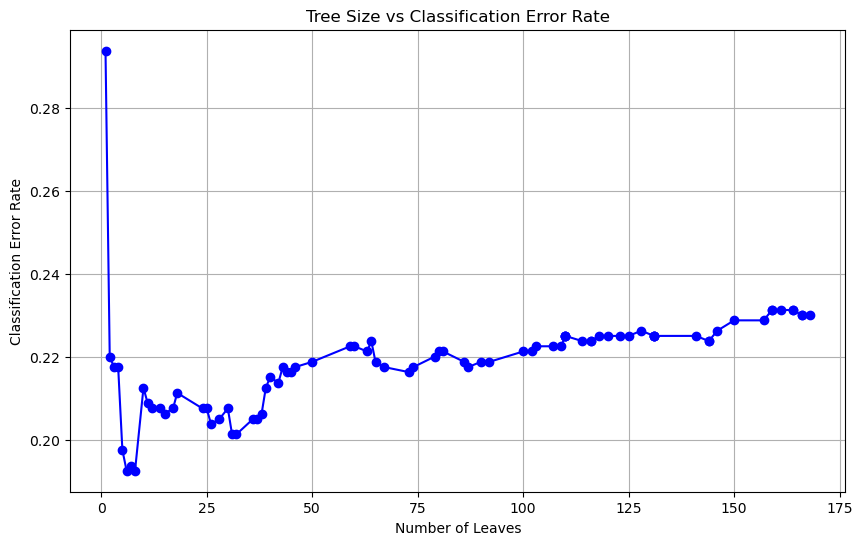

In [236]:
#g) Produce a plot with tree size on the x-axis and cross-validated classifcation error rate on the y-axis.
mean_test_scores = grid.cv_results_['mean_test_score']
ccp_alphas = ccp_path.ccp_alphas 
error_rates = 1 - mean_test_scores

average_leaves = []

for ccp_alpha in ccp_alphas:
    clf = DTC(criterion='entropy', ccp_alpha=ccp_alpha, random_state=0)
    clf.fit(X_train, y_train)
    average_leaves.append(clf.tree_.n_leaves)

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(average_leaves, error_rates, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Leaves')
plt.ylabel('Classification Error Rate')
plt.title('Tree Size vs Classification Error Rate')
plt.grid(True)
plt.show()

In [237]:
#h) Which tree size corresponds to the lowest cross-validated classifcation error rate?
min_error_index = np.argmin(error_rates)
optimal_leaves = average_leaves[min_error_index]
lowest_error_rate = error_rates[min_error_index]
print(optimal_leaves,lowest_error_rate)

8 0.1924999999999999


In [241]:
print(accuracy_score(y_test, 
                     best_.predict(X_test)))

0.8111111111111111


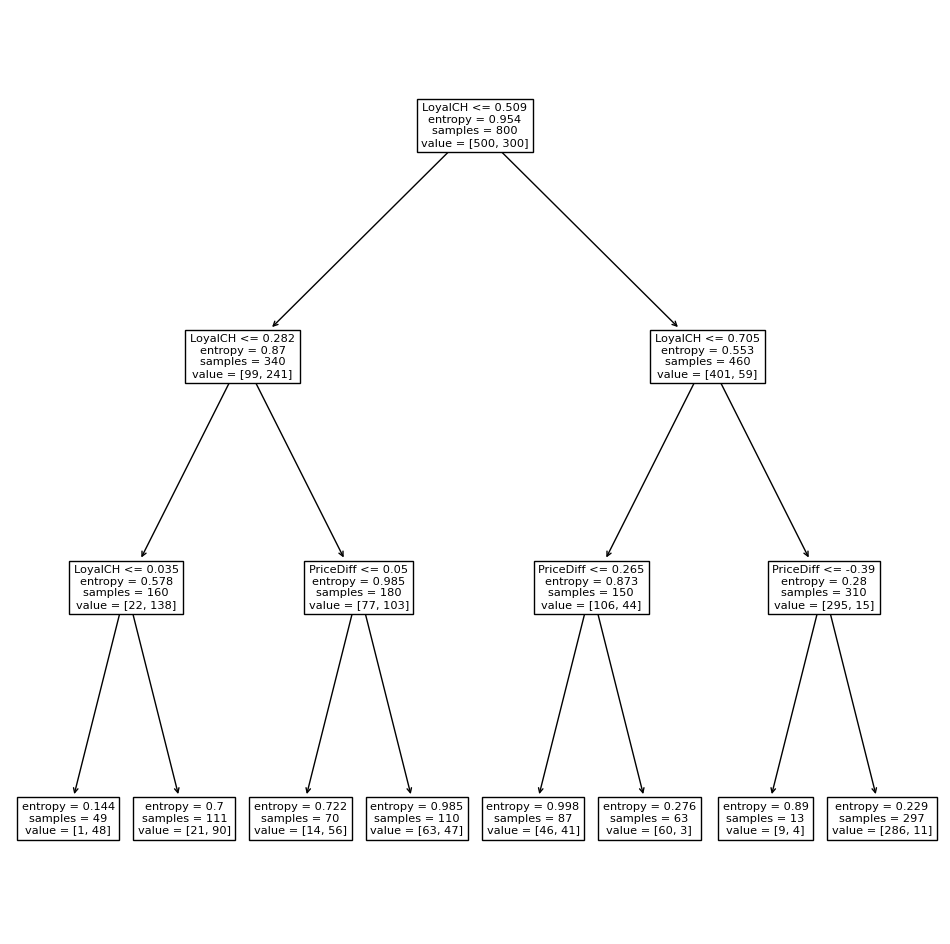

In [238]:
#i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation.
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

In [ ]:
#training error:
# pruned : 0.1924999999999999 #higher
#unpruned trees:1-0.99125 = 0.00875

In [ ]:
#test error rate
#pruned: 1-0.8111111111111111 =0.18889
#unpruned trees:0.22962962962962963 #higher

In [ ]:
#10. We now use boosting to predict Salary in the Hitters data set

In [ ]:
#a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [251]:
Hitters = load_data('Hitters')
Hitters = Hitters.dropna(subset=['Salary'])
Hitters['Salary'] = np.log(Hitters['Salary'])

In [345]:
#b)
model = MS(Hitters.columns.drop('Salary'), intercept=False)
D = model.fit_transform(Hitters)
feature_names = list(D.columns)
X = np.asarray(D)
y = Hitters['Salary'].values 

X_train = X[:200]
y_train = y[:200]

X_test = X[200:]
y_test = y[200:]

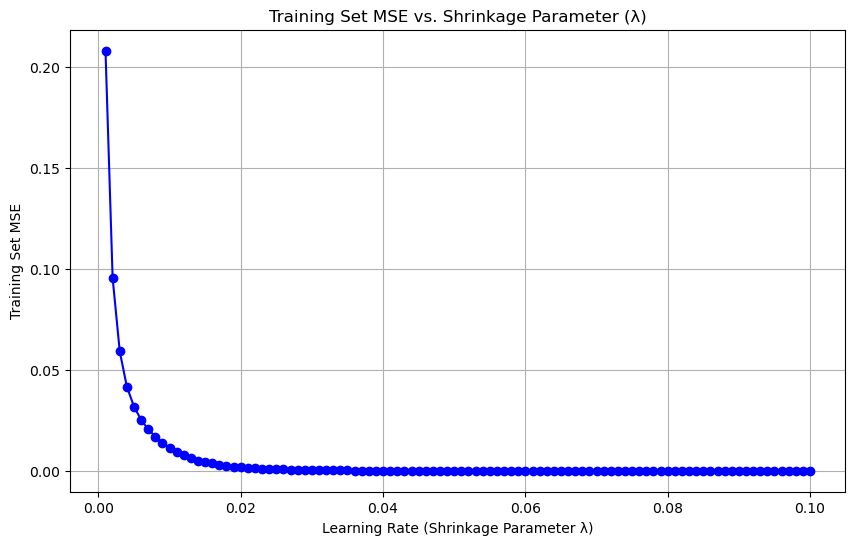

5.709749628793786e-09


In [271]:
#c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ
learning_rates = np.arange(0.001, 0.101, 0.001)
mse_values = []

for learning_rate in learning_rates:
    boost_Hitters = GBR(n_estimators=1000,# 1000 trees
                   learning_rate=learning_rate,
                   max_depth=3, #limits the depth of each tree.
                   random_state=0)
    boost_Hitters.fit(X_train, y_train)
    y_train_pred = boost_Hitters.predict(X_train)
    
    mse = mean_squared_error(y_train, y_train_pred)
    mse_values.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Learning Rate (Shrinkage Parameter λ)')
plt.ylabel('Training Set MSE')
plt.title('Training Set MSE vs. Shrinkage Parameter (λ)')
plt.grid(True)
plt.show()

print(min(mse_values))

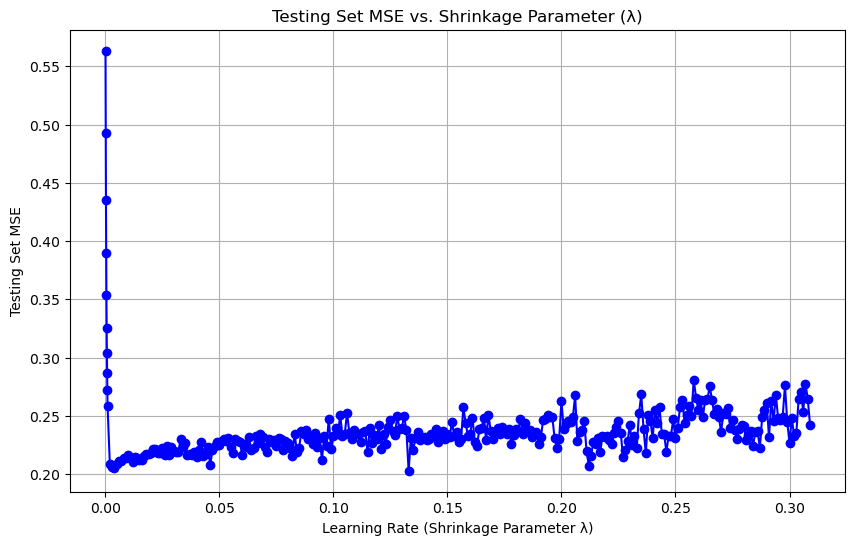

Optimal Learning Rate: 0.133
Minimum Test MSE: 0.20294707390065608


In [332]:
#(d) Produce a plot with diferent shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.
learning_rates = np.concatenate([np.arange(0.0001, 0.001, 0.0001), np.arange(0.001, 0.31, 0.001)])
mse_values = []

for learning_rate in learning_rates:
    boost_Hitters = GBR(n_estimators=1000,# 1000 trees
                   learning_rate=learning_rate,
                   max_depth=3, #limits the depth of each tree.
                   random_state=0)
    boost_Hitters.fit(X_train, y_train)
    y_test_pred = boost_Hitters.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    mse_values.append(test_mse)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Learning Rate (Shrinkage Parameter λ)')
plt.ylabel('Testing Set MSE')
plt.title('Testing Set MSE vs. Shrinkage Parameter (λ)')
plt.grid(True)
plt.show()

optimal_index = np.argmin(mse_values)  # Index of the minimum MSE
optimal_learning_rate = learning_rates[optimal_index]  # Corresponding learning rate
min_mse = mse_values[optimal_index]  # Minimum MSE

print(f"Optimal Learning Rate: {optimal_learning_rate}")
print(f"Minimum Test MSE: {min_mse}")

In [ ]:
#e) OLS & chapter 6 labs

In [313]:
# Linear Regression
X_train_with_const = sm.add_constant(X_train)  
X_test_with_const = sm.add_constant(X_test)    

model_ols = sm.OLS(y_train, X_train_with_const)
model_ols = model_ols.fit()

test_pred = model_ols.predict(X_test_with_const)

# Calculate the test MSE
reg_mse = mean_squared_error(y_test, test_pred)

In [314]:
reg_mse

0.49179593754549095

In [302]:
# Lasso Regression
Xs_train = X_train - X_train.mean(0)[None,:] #[None,:] add a dimension
X_scale = X_train.std(0)
Xs_train = Xs_train / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / y_train.std() # np.linspace(8, -2, 100) create an array of 100 equally spaced numbers between 8 and −2.

In [307]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1, #change 0 to 1 in lasso
                           cv=kfold)
scaler = StandardScaler(with_mean=True, with_std=True)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_train, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.003085779187965322

In [309]:
lambdas , soln_array = skl.Lasso.path(Xs_train,
                                      y_train,
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

In [ ]:
#test error

In [312]:
y_test_pred = pipeCV.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mse

0.4712932708728221

In [350]:
boost_Hitters

GradientBoostingRegressor(learning_rate=0.133, n_estimators=1000,
                          random_state=0)

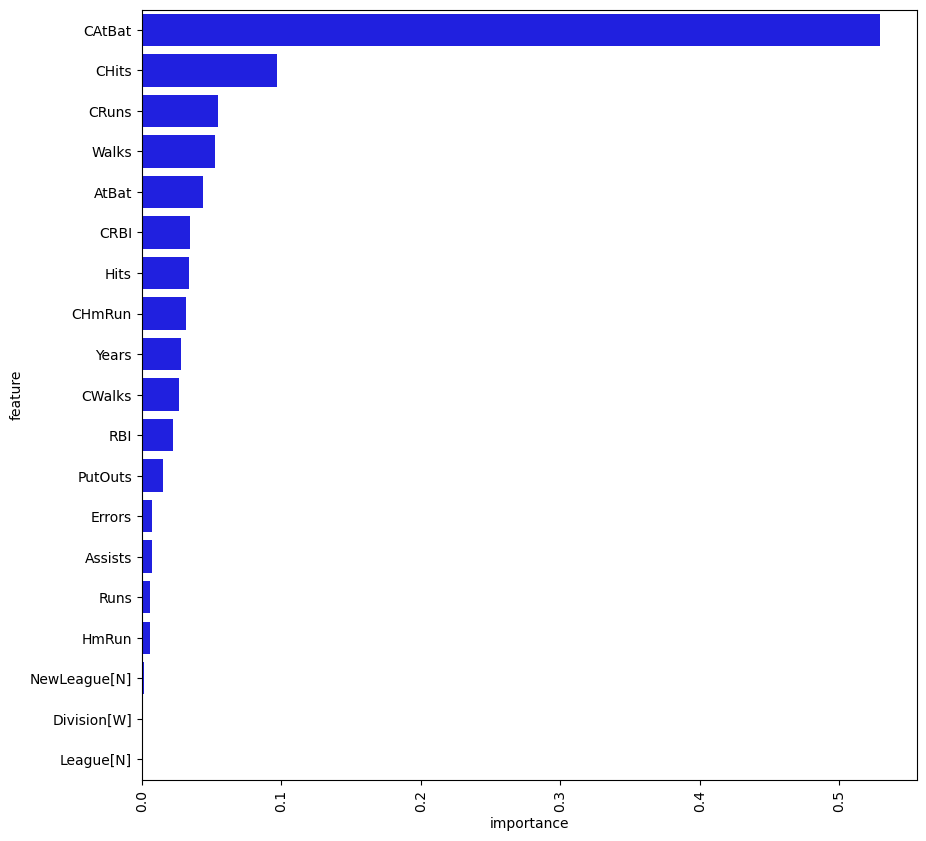

In [356]:
#f) Which variables appear to be the most important predictors
boost_Hitters = GBR(n_estimators=1000,# 1000 trees
                    learning_rate=0.133,
                    random_state=0)
boost_Hitters = boost_Hitters.fit(X_train, y_train)

# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': feature_names, 'importance': boost_Hitters.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

In [ ]:
#most important predictors:CAtBat

In [364]:
#g) apply bagging to the training set
bag_Hitters = RF(max_features=X_train.shape[1], #bagging,no need for intercept
                 n_estimators=1000, 
                 random_state=0).fit(X_train, y_train)
y_hat_bag = bag_Hitters.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

0.23031631938774214

In [365]:
#########11

In [367]:
Caravan = load_data("Caravan")

In [369]:
#a)
model = MS(Caravan.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(Caravan)
feature_names = list(D.columns)
X = np.asarray(D)
y = Caravan['Purchase'].values 

X_train = X[:1000]
y_train = y[:1000]

X_test = X[1000:]
y_test = y[1000:]

In [380]:
#b)boosting
boost_Caravan = GBC(n_estimators=1000,# want 1000 trees
                   learning_rate=0.01,
                   random_state=0)
boost_Caravan.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=0)

In [ ]:
#PPERSAUT

In [403]:
feature_imp = pd.DataFrame(
    {'importance':boost_Caravan.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
PPERSAUT,0.074515
MOSTYPE,0.065189
ABRAND,0.057117
MGODGE,0.052929
MKOOPKLA,0.047575
...,...
APERSONG,0.000000
PBESAUT,0.000000
PVRAAUT,0.000000
PWERKT,0.000000


In [382]:
#c)make a purchase if the estimated probability of purchase is greater than 20 %

In [400]:
y_test_prob = boost_Caravan.predict_proba(X_test)[:, 1]  
y_test_pred = np.where(y_test_prob > 0.2, 'Yes', 'No')

conf_matrix = confusion_matrix(y_test, y_test_pred, labels=['No', 'Yes'])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
            Predicted No  Predicted Yes
Actual No           4336            197
Actual Yes           251             38


In [402]:
#fraction of the people predicted to make a purchase do in fact make one?  16.17%
38/(197+38)

0.16170212765957448

In [ ]:
# from lab4 KNN 9/(53+9)  
#training/testing sets different

In [ ]:
#12.Apply boosting, bagging, random forests, and BART to a data set of your choice. 

In [408]:
Auto = load_data("Auto")
model = MS(Auto.columns.drop('mpg'), intercept=False)
D = model.fit_transform(Auto)
feature_names = list(D.columns)
X = np.asarray(D)
#use 30% of the data for the test set.
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                               Auto['mpg'],
                               test_size=0.3,
                               random_state=0)

In [ ]:
#boosting

In [412]:
boost_Auto = GBR(n_estimators=5000,# want 5000 trees
                 learning_rate=0.001,
                 max_depth=3, #limits the depth of each tree.
                 random_state=0)
boost_Auto.fit(X_train, y_train)

# use the boosted model to predict medv
y_hat_boost = boost_Auto.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

8.481260088923202

In [ ]:
#BART

In [413]:
bart_Auto = BART(random_state=0, burnin=5, ndraw=15)
bart_Auto.fit(X_train, y_train)

#test error of BART is similar to that of random forest
yhat_test = bart_Auto.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

7.41679924750433

In [ ]:
#bagging

9.024682898305084

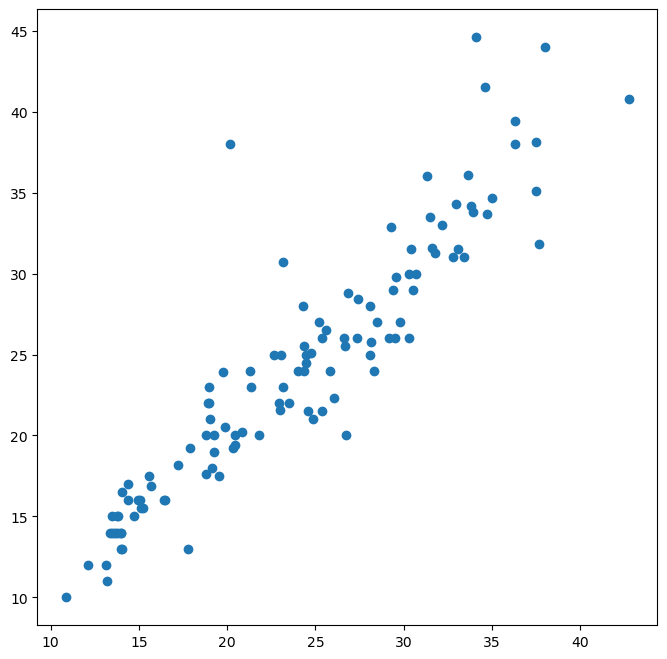

In [414]:
bag_Auto = RF(max_features=X_train.shape[1], random_state=0)
bag_Auto.fit(X_train, y_train)

ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_Auto.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

9.301961516949154

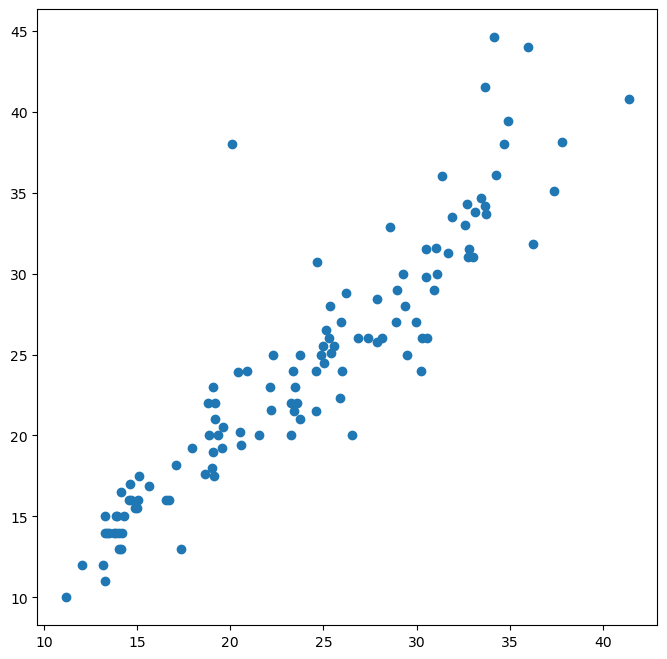

In [417]:
rf_Auto = RF(max_features=int(np.sqrt(X_train.shape[1])), random_state=0)
rf_Auto.fit(X_train, y_train)

ax = subplots(figsize=(8,8))[1]
y_hat_bag = rf_Auto.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [ ]:
#BART results in the least MSE